# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


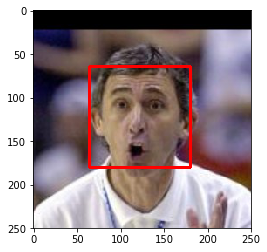

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[308])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    faces = face_cascade.detectMultiScale(gray)
    for (x,y,w,h) in faces:
    # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ (code is below)

97% of human images were detected as human and 11% of dog images were detected as human. 

97 % of human images detected as human
11 % of dog images detected as human


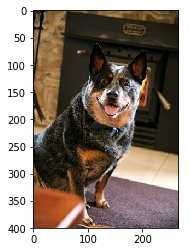

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

cnt_hum = 0
for file in human_files_short:
    global cnt_hum
    if face_detector(file):
        cnt_hum = cnt_hum + 1
        
cnt_dog = 0
for file in dog_files_short:
    global cnt_dog
    if face_detector(file):
        cnt_dog = cnt_dog + 1
        
print(cnt_hum,'% of human images detected as human')
print(cnt_dog,'% of dog images detected as human')      



        

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

**Answer to question 2**

Expecting the user to provide an image with a clearly shown face is acceptable in testing and research environments, 
but in actual products such expectation would burden and frustrate the end user. Our algorithm should ideally have the 
capability to detect humans in images that are not specially prepared and in which clear, centered faces may not be available. 

To achieve this functionality, we would have to design and train a network specifically on partially obscured faces. Moreover, 
we may have to think of extracting human-specific features beyond the face (if the purpose is limited to simply detecting humans).

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [10]:
dog_predict = {0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma maculatum',
 29: 'axolotl, mud puppy, Ambystoma mexicanum',
 30: 'bullfrog, Rana catesbeiana',
 31: 'tree frog, tree-frog',
 32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 33: 'loggerhead, loggerhead turtle, Caretta caretta',
 34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle, box tortoise',
 38: 'banded gecko',
 39: 'common iguana, iguana, Iguana iguana',
 40: 'American chameleon, anole, Anolis carolinensis',
 41: 'whiptail, whiptail lizard',
 42: 'agama',
 43: 'frilled lizard, Chlamydosaurus kingi',
 44: 'alligator lizard',
 45: 'Gila monster, Heloderma suspectum',
 46: 'green lizard, Lacerta viridis',
 47: 'African chameleon, Chamaeleo chamaeleon',
 48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
 50: 'American alligator, Alligator mississipiensis',
 51: 'triceratops',
 52: 'thunder snake, worm snake, Carphophis amoenus',
 53: 'ringneck snake, ring-necked snake, ring snake',
 54: 'hognose snake, puff adder, sand viper',
 55: 'green snake, grass snake',
 56: 'king snake, kingsnake',
 57: 'garter snake, grass snake',
 58: 'water snake',
 59: 'vine snake',
 60: 'night snake, Hypsiglena torquata',
 61: 'boa constrictor, Constrictor constrictor',
 62: 'rock python, rock snake, Python sebae',
 63: 'Indian cobra, Naja naja',
 64: 'green mamba',
 65: 'sea snake',
 66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
 69: 'trilobite',
 70: 'harvestman, daddy longlegs, Phalangium opilio',
 71: 'scorpion',
 72: 'black and gold garden spider, Argiope aurantia',
 73: 'barn spider, Araneus cavaticus',
 74: 'garden spider, Aranea diademata',
 75: 'black widow, Latrodectus mactans',
 76: 'tarantula',
 77: 'wolf spider, hunting spider',
 78: 'tick',
 79: 'centipede',
 80: 'black grouse',
 81: 'ptarmigan',
 82: 'ruffed grouse, partridge, Bonasa umbellus',
 83: 'prairie chicken, prairie grouse, prairie fowl',
 84: 'peacock',
 85: 'quail',
 86: 'partridge',
 87: 'African grey, African gray, Psittacus erithacus',
 88: 'macaw',
 89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 90: 'lorikeet',
 91: 'coucal',
 92: 'bee eater',
 93: 'hornbill',
 94: 'hummingbird',
 95: 'jacamar',
 96: 'toucan',
 97: 'drake',
 98: 'red-breasted merganser, Mergus serrator',
 99: 'goose',
 100: 'black swan, Cygnus atratus',
 101: 'tusker',
 102: 'echidna, spiny anteater, anteater',
 103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 104: 'wallaby, brush kangaroo',
 105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 106: 'wombat',
 107: 'jellyfish',
 108: 'sea anemone, anemone',
 109: 'brain coral',
 110: 'flatworm, platyhelminth',
 111: 'nematode, nematode worm, roundworm',
 112: 'conch',
 113: 'snail',
 114: 'slug',
 115: 'sea slug, nudibranch',
 116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 117: 'chambered nautilus, pearly nautilus, nautilus',
 118: 'Dungeness crab, Cancer magister',
 119: 'rock crab, Cancer irroratus',
 120: 'fiddler crab',
 121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
 122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 124: 'crayfish, crawfish, crawdad, crawdaddy',
 125: 'hermit crab',
 126: 'isopod',
 127: 'white stork, Ciconia ciconia',
 128: 'black stork, Ciconia nigra',
 129: 'spoonbill',
 130: 'flamingo',
 131: 'little blue heron, Egretta caerulea',
 132: 'American egret, great white heron, Egretta albus',
 133: 'bittern',
 134: 'crane',
 135: 'limpkin, Aramus pictus',
 136: 'European gallinule, Porphyrio porphyrio',
 137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 138: 'bustard',
 139: 'ruddy turnstone, Arenaria interpres',
 140: 'red-backed sandpiper, dunlin, Erolia alpina',
 141: 'redshank, Tringa totanus',
 142: 'dowitcher',
 143: 'oystercatcher, oyster catcher',
 144: 'pelican',
 145: 'king penguin, Aptenodytes patagonica',
 146: 'albatross, mollymawk',
 147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 149: 'dugong, Dugong dugon',
 150: 'sea lion',
 151: 'Chihuahua',
 152: 'Japanese spaniel',
 153: 'Maltese dog, Maltese terrier, Maltese',
 154: 'Pekinese, Pekingese, Peke',
 155: 'Shih-Tzu',
 156: 'Blenheim spaniel',
 157: 'papillon',
 158: 'toy terrier',
 159: 'Rhodesian ridgeback',
 160: 'Afghan hound, Afghan',
 161: 'basset, basset hound',
 162: 'beagle',
 163: 'bloodhound, sleuthhound',
 164: 'bluetick',
 165: 'black-and-tan coonhound',
 166: 'Walker hound, Walker foxhound',
 167: 'English foxhound',
 168: 'redbone',
 169: 'borzoi, Russian wolfhound',
 170: 'Irish wolfhound',
 171: 'Italian greyhound',
 172: 'whippet',
 173: 'Ibizan hound, Ibizan Podenco',
 174: 'Norwegian elkhound, elkhound',
 175: 'otterhound, otter hound',
 176: 'Saluki, gazelle hound',
 177: 'Scottish deerhound, deerhound',
 178: 'Weimaraner',
 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
 180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 181: 'Bedlington terrier',
 182: 'Border terrier',
 183: 'Kerry blue terrier',
 184: 'Irish terrier',
 185: 'Norfolk terrier',
 186: 'Norwich terrier',
 187: 'Yorkshire terrier',
 188: 'wire-haired fox terrier',
 189: 'Lakeland terrier',
 190: 'Sealyham terrier, Sealyham',
 191: 'Airedale, Airedale terrier',
 192: 'cairn, cairn terrier',
 193: 'Australian terrier',
 194: 'Dandie Dinmont, Dandie Dinmont terrier',
 195: 'Boston bull, Boston terrier',
 196: 'miniature schnauzer',
 197: 'giant schnauzer',
 198: 'standard schnauzer',
 199: 'Scotch terrier, Scottish terrier, Scottie',
 200: 'Tibetan terrier, chrysanthemum dog',
 201: 'silky terrier, Sydney silky',
 202: 'soft-coated wheaten terrier',
 203: 'West Highland white terrier',
 204: 'Lhasa, Lhasa apso',
 205: 'flat-coated retriever',
 206: 'curly-coated retriever',
 207: 'golden retriever',
 208: 'Labrador retriever',
 209: 'Chesapeake Bay retriever',
 210: 'German short-haired pointer',
 211: 'vizsla, Hungarian pointer',
 212: 'English setter',
 213: 'Irish setter, red setter',
 214: 'Gordon setter',
 215: 'Brittany spaniel',
 216: 'clumber, clumber spaniel',
 217: 'English springer, English springer spaniel',
 218: 'Welsh springer spaniel',
 219: 'cocker spaniel, English cocker spaniel, cocker',
 220: 'Sussex spaniel',
 221: 'Irish water spaniel',
 222: 'kuvasz',
 223: 'schipperke',
 224: 'groenendael',
 225: 'malinois',
 226: 'briard',
 227: 'kelpie',
 228: 'komondor',
 229: 'Old English sheepdog, bobtail',
 230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
 231: 'collie',
 232: 'Border collie',
 233: 'Bouvier des Flandres, Bouviers des Flandres',
 234: 'Rottweiler',
 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
 236: 'Doberman, Doberman pinscher',
 237: 'miniature pinscher',
 238: 'Greater Swiss Mountain dog',
 239: 'Bernese mountain dog',
 240: 'Appenzeller',
 241: 'EntleBucher',
 242: 'boxer',
 243: 'bull mastiff',
 244: 'Tibetan mastiff',
 245: 'French bulldog',
 246: 'Great Dane',
 247: 'Saint Bernard, St Bernard',
 248: 'Eskimo dog, husky',
 249: 'malamute, malemute, Alaskan malamute',
 250: 'Siberian husky',
 251: 'dalmatian, coach dog, carriage dog',
 252: 'affenpinscher, monkey pinscher, monkey dog',
 253: 'basenji',
 254: 'pug, pug-dog',
 255: 'Leonberg',
 256: 'Newfoundland, Newfoundland dog',
 257: 'Great Pyrenees',
 258: 'Samoyed, Samoyede',
 259: 'Pomeranian',
 260: 'chow, chow chow',
 261: 'keeshond',
 262: 'Brabancon griffon',
 263: 'Pembroke, Pembroke Welsh corgi',
 264: 'Cardigan, Cardigan Welsh corgi',
 265: 'toy poodle',
 266: 'miniature poodle',
 267: 'standard poodle',
 268: 'Mexican hairless',
 269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
 270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
 271: 'red wolf, maned wolf, Canis rufus, Canis niger',
 272: 'coyote, prairie wolf, brush wolf, Canis latrans',
 273: 'dingo, warrigal, warragal, Canis dingo',
 274: 'dhole, Cuon alpinus',
 275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 276: 'hyena, hyaena',
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
 281: 'tabby, tabby cat',
 282: 'tiger cat',
 283: 'Persian cat',
 284: 'Siamese cat, Siamese',
 285: 'Egyptian cat',
 286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 287: 'lynx, catamount',
 288: 'leopard, Panthera pardus',
 289: 'snow leopard, ounce, Panthera uncia',
 290: 'jaguar, panther, Panthera onca, Felis onca',
 291: 'lion, king of beasts, Panthera leo',
 292: 'tiger, Panthera tigris',
 293: 'cheetah, chetah, Acinonyx jubatus',
 294: 'brown bear, bruin, Ursus arctos',
 295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
 297: 'sloth bear, Melursus ursinus, Ursus ursinus',
 298: 'mongoose',
 299: 'meerkat, mierkat',
 300: 'tiger beetle',
 301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 302: 'ground beetle, carabid beetle',
 303: 'long-horned beetle, longicorn, longicorn beetle',
 304: 'leaf beetle, chrysomelid',
 305: 'dung beetle',
 306: 'rhinoceros beetle',
 307: 'weevil',
 308: 'fly',
 309: 'bee',
 310: 'ant, emmet, pismire',
 311: 'grasshopper, hopper',
 312: 'cricket',
 313: 'walking stick, walkingstick, stick insect',
 314: 'cockroach, roach',
 315: 'mantis, mantid',
 316: 'cicada, cicala',
 317: 'leafhopper',
 318: 'lacewing, lacewing fly',
 319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 320: 'damselfly',
 321: 'admiral',
 322: 'ringlet, ringlet butterfly',
 323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
 324: 'cabbage butterfly',
 325: 'sulphur butterfly, sulfur butterfly',
 326: 'lycaenid, lycaenid butterfly',
 327: 'starfish, sea star',
 328: 'sea urchin',
 329: 'sea cucumber, holothurian',
 330: 'wood rabbit, cottontail, cottontail rabbit',
 331: 'hare',
 332: 'Angora, Angora rabbit',
 333: 'hamster',
 334: 'porcupine, hedgehog',
 335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
 336: 'marmot',
 337: 'beaver',
 338: 'guinea pig, Cavia cobaya',
 339: 'sorrel',
 340: 'zebra',
 341: 'hog, pig, grunter, squealer, Sus scrofa',
 342: 'wild boar, boar, Sus scrofa',
 343: 'warthog',
 344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
 345: 'ox',
 346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 347: 'bison',
 348: 'ram, tup',
 349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
 350: 'ibex, Capra ibex',
 351: 'hartebeest',
 352: 'impala, Aepyceros melampus',
 353: 'gazelle',
 354: 'Arabian camel, dromedary, Camelus dromedarius',
 355: 'llama',
 356: 'weasel',
 357: 'mink',
 358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
 359: 'black-footed ferret, ferret, Mustela nigripes',
 360: 'otter',
 361: 'skunk, polecat, wood pussy',
 362: 'badger',
 363: 'armadillo',
 364: 'three-toed sloth, ai, Bradypus tridactylus',
 365: 'orangutan, orang, orangutang, Pongo pygmaeus',
 366: 'gorilla, Gorilla gorilla',
 367: 'chimpanzee, chimp, Pan troglodytes',
 368: 'gibbon, Hylobates lar',
 369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
 370: 'guenon, guenon monkey',
 371: 'patas, hussar monkey, Erythrocebus patas',
 372: 'baboon',
 373: 'macaque',
 374: 'langur',
 375: 'colobus, colobus monkey',
 376: 'proboscis monkey, Nasalis larvatus',
 377: 'marmoset',
 378: 'capuchin, ringtail, Cebus capucinus',
 379: 'howler monkey, howler',
 380: 'titi, titi monkey',
 381: 'spider monkey, Ateles geoffroyi',
 382: 'squirrel monkey, Saimiri sciureus',
 383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
 384: 'indri, indris, Indri indri, Indri brevicaudatus',
 385: 'Indian elephant, Elephas maximus',
 386: 'African elephant, Loxodonta africana',
 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
 389: 'barracouta, snoek',
 390: 'eel',
 391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
 392: 'rock beauty, Holocanthus tricolor',
 393: 'anemone fish',
 394: 'sturgeon',
 395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
 396: 'lionfish',
 397: 'puffer, pufferfish, blowfish, globefish',
 398: 'abacus',
 399: 'abaya',
 400: "academic gown, academic robe, judge's robe",
 401: 'accordion, piano accordion, squeeze box',
 402: 'acoustic guitar',
 403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
 404: 'airliner',
 405: 'airship, dirigible',
 406: 'altar',
 407: 'ambulance',
 408: 'amphibian, amphibious vehicle',
 409: 'analog clock',
 410: 'apiary, bee house',
 411: 'apron',
 412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 413: 'assault rifle, assault gun',
 414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 415: 'bakery, bakeshop, bakehouse',
 416: 'balance beam, beam',
 417: 'balloon',
 418: 'ballpoint, ballpoint pen, ballpen, Biro',
 419: 'Band Aid',
 420: 'banjo',
 421: 'bannister, banister, balustrade, balusters, handrail',
 422: 'barbell',
 423: 'barber chair',
 424: 'barbershop',
 425: 'barn',
 426: 'barometer',
 427: 'barrel, cask',
 428: 'barrow, garden cart, lawn cart, wheelbarrow',
 429: 'baseball',
 430: 'basketball',
 431: 'bassinet',
 432: 'bassoon',
 433: 'bathing cap, swimming cap',
 434: 'bath towel',
 435: 'bathtub, bathing tub, bath, tub',
 436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 437: 'beacon, lighthouse, beacon light, pharos',
 438: 'beaker',
 439: 'bearskin, busby, shako',
 440: 'beer bottle',
 441: 'beer glass',
 442: 'bell cote, bell cot',
 443: 'bib',
 444: 'bicycle-built-for-two, tandem bicycle, tandem',
 445: 'bikini, two-piece',
 446: 'binder, ring-binder',
 447: 'binoculars, field glasses, opera glasses',
 448: 'birdhouse',
 449: 'boathouse',
 450: 'bobsled, bobsleigh, bob',
 451: 'bolo tie, bolo, bola tie, bola',
 452: 'bonnet, poke bonnet',
 453: 'bookcase',
 454: 'bookshop, bookstore, bookstall',
 455: 'bottlecap',
 456: 'bow',
 457: 'bow tie, bow-tie, bowtie',
 458: 'brass, memorial tablet, plaque',
 459: 'brassiere, bra, bandeau',
 460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
 461: 'breastplate, aegis, egis',
 462: 'broom',
 463: 'bucket, pail',
 464: 'buckle',
 465: 'bulletproof vest',
 466: 'bullet train, bullet',
 467: 'butcher shop, meat market',
 468: 'cab, hack, taxi, taxicab',
 469: 'caldron, cauldron',
 470: 'candle, taper, wax light',
 471: 'cannon',
 472: 'canoe',
 473: 'can opener, tin opener',
 474: 'cardigan',
 475: 'car mirror',
 476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
 477: "carpenter's kit, tool kit",
 478: 'carton',
 479: 'car wheel',
 480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
 481: 'cassette',
 482: 'cassette player',
 483: 'castle',
 484: 'catamaran',
 485: 'CD player',
 486: 'cello, violoncello',
 487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
 488: 'chain',
 489: 'chainlink fence',
 490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 491: 'chain saw, chainsaw',
 492: 'chest',
 493: 'chiffonier, commode',
 494: 'chime, bell, gong',
 495: 'china cabinet, china closet',
 496: 'Christmas stocking',
 497: 'church, church building',
 498: 'cinema, movie theater, movie theatre, movie house, picture palace',
 499: 'cleaver, meat cleaver, chopper',
 500: 'cliff dwelling',
 501: 'cloak',
 502: 'clog, geta, patten, sabot',
 503: 'cocktail shaker',
 504: 'coffee mug',
 505: 'coffeepot',
 506: 'coil, spiral, volute, whorl, helix',
 507: 'combination lock',
 508: 'computer keyboard, keypad',
 509: 'confectionery, confectionary, candy store',
 510: 'container ship, containership, container vessel',
 511: 'convertible',
 512: 'corkscrew, bottle screw',
 513: 'cornet, horn, trumpet, trump',
 514: 'cowboy boot',
 515: 'cowboy hat, ten-gallon hat',
 516: 'cradle',
 517: 'crane',
 518: 'crash helmet',
 519: 'crate',
 520: 'crib, cot',
 521: 'Crock Pot',
 522: 'croquet ball',
 523: 'crutch',
 524: 'cuirass',
 525: 'dam, dike, dyke',
 526: 'desk',
 527: 'desktop computer',
 528: 'dial telephone, dial phone',
 529: 'diaper, nappy, napkin',
 530: 'digital clock',
 531: 'digital watch',
 532: 'dining table, board',
 533: 'dishrag, dishcloth',
 534: 'dishwasher, dish washer, dishwashing machine',
 535: 'disk brake, disc brake',
 536: 'dock, dockage, docking facility',
 537: 'dogsled, dog sled, dog sleigh',
 538: 'dome',
 539: 'doormat, welcome mat',
 540: 'drilling platform, offshore rig',
 541: 'drum, membranophone, tympan',
 542: 'drumstick',
 543: 'dumbbell',
 544: 'Dutch oven',
 545: 'electric fan, blower',
 546: 'electric guitar',
 547: 'electric locomotive',
 548: 'entertainment center',
 549: 'envelope',
 550: 'espresso maker',
 551: 'face powder',
 552: 'feather boa, boa',
 553: 'file, file cabinet, filing cabinet',
 554: 'fireboat',
 555: 'fire engine, fire truck',
 556: 'fire screen, fireguard',
 557: 'flagpole, flagstaff',
 558: 'flute, transverse flute',
 559: 'folding chair',
 560: 'football helmet',
 561: 'forklift',
 562: 'fountain',
 563: 'fountain pen',
 564: 'four-poster',
 565: 'freight car',
 566: 'French horn, horn',
 567: 'frying pan, frypan, skillet',
 568: 'fur coat',
 569: 'garbage truck, dustcart',
 570: 'gasmask, respirator, gas helmet',
 571: 'gas pump, gasoline pump, petrol pump, island dispenser',
 572: 'goblet',
 573: 'go-kart',
 574: 'golf ball',
 575: 'golfcart, golf cart',
 576: 'gondola',
 577: 'gong, tam-tam',
 578: 'gown',
 579: 'grand piano, grand',
 580: 'greenhouse, nursery, glasshouse',
 581: 'grille, radiator grille',
 582: 'grocery store, grocery, food market, market',
 583: 'guillotine',
 584: 'hair slide',
 585: 'hair spray',
 586: 'half track',
 587: 'hammer',
 588: 'hamper',
 589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
 590: 'hand-held computer, hand-held microcomputer',
 591: 'handkerchief, hankie, hanky, hankey',
 592: 'hard disc, hard disk, fixed disk',
 593: 'harmonica, mouth organ, harp, mouth harp',
 594: 'harp',
 595: 'harvester, reaper',
 596: 'hatchet',
 597: 'holster',
 598: 'home theater, home theatre',
 599: 'honeycomb',
 600: 'hook, claw',
 601: 'hoopskirt, crinoline',
 602: 'horizontal bar, high bar',
 603: 'horse cart, horse-cart',
 604: 'hourglass',
 605: 'iPod',
 606: 'iron, smoothing iron',
 607: "jack-o'-lantern",
 608: 'jean, blue jean, denim',
 609: 'jeep, landrover',
 610: 'jersey, T-shirt, tee shirt',
 611: 'jigsaw puzzle',
 612: 'jinrikisha, ricksha, rickshaw',
 613: 'joystick',
 614: 'kimono',
 615: 'knee pad',
 616: 'knot',
 617: 'lab coat, laboratory coat',
 618: 'ladle',
 619: 'lampshade, lamp shade',
 620: 'laptop, laptop computer',
 621: 'lawn mower, mower',
 622: 'lens cap, lens cover',
 623: 'letter opener, paper knife, paperknife',
 624: 'library',
 625: 'lifeboat',
 626: 'lighter, light, igniter, ignitor',
 627: 'limousine, limo',
 628: 'liner, ocean liner',
 629: 'lipstick, lip rouge',
 630: 'Loafer',
 631: 'lotion',
 632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 633: "loupe, jeweler's loupe",
 634: 'lumbermill, sawmill',
 635: 'magnetic compass',
 636: 'mailbag, postbag',
 637: 'mailbox, letter box',
 638: 'maillot',
 639: 'maillot, tank suit',
 640: 'manhole cover',
 641: 'maraca',
 642: 'marimba, xylophone',
 643: 'mask',
 644: 'matchstick',
 645: 'maypole',
 646: 'maze, labyrinth',
 647: 'measuring cup',
 648: 'medicine chest, medicine cabinet',
 649: 'megalith, megalithic structure',
 650: 'microphone, mike',
 651: 'microwave, microwave oven',
 652: 'military uniform',
 653: 'milk can',
 654: 'minibus',
 655: 'miniskirt, mini',
 656: 'minivan',
 657: 'missile',
 658: 'mitten',
 659: 'mixing bowl',
 660: 'mobile home, manufactured home',
 661: 'Model T',
 662: 'modem',
 663: 'monastery',
 664: 'monitor',
 665: 'moped',
 666: 'mortar',
 667: 'mortarboard',
 668: 'mosque',
 669: 'mosquito net',
 670: 'motor scooter, scooter',
 671: 'mountain bike, all-terrain bike, off-roader',
 672: 'mountain tent',
 673: 'mouse, computer mouse',
 674: 'mousetrap',
 675: 'moving van',
 676: 'muzzle',
 677: 'nail',
 678: 'neck brace',
 679: 'necklace',
 680: 'nipple',
 681: 'notebook, notebook computer',
 682: 'obelisk',
 683: 'oboe, hautboy, hautbois',
 684: 'ocarina, sweet potato',
 685: 'odometer, hodometer, mileometer, milometer',
 686: 'oil filter',
 687: 'organ, pipe organ',
 688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 689: 'overskirt',
 690: 'oxcart',
 691: 'oxygen mask',
 692: 'packet',
 693: 'paddle, boat paddle',
 694: 'paddlewheel, paddle wheel',
 695: 'padlock',
 696: 'paintbrush',
 697: "pajama, pyjama, pj's, jammies",
 698: 'palace',
 699: 'panpipe, pandean pipe, syrinx',
 700: 'paper towel',
 701: 'parachute, chute',
 702: 'parallel bars, bars',
 703: 'park bench',
 704: 'parking meter',
 705: 'passenger car, coach, carriage',
 706: 'patio, terrace',
 707: 'pay-phone, pay-station',
 708: 'pedestal, plinth, footstall',
 709: 'pencil box, pencil case',
 710: 'pencil sharpener',
 711: 'perfume, essence',
 712: 'Petri dish',
 713: 'photocopier',
 714: 'pick, plectrum, plectron',
 715: 'pickelhaube',
 716: 'picket fence, paling',
 717: 'pickup, pickup truck',
 718: 'pier',
 719: 'piggy bank, penny bank',
 720: 'pill bottle',
 721: 'pillow',
 722: 'ping-pong ball',
 723: 'pinwheel',
 724: 'pirate, pirate ship',
 725: 'pitcher, ewer',
 726: "plane, carpenter's plane, woodworking plane",
 727: 'planetarium',
 728: 'plastic bag',
 729: 'plate rack',
 730: 'plow, plough',
 731: "plunger, plumber's helper",
 732: 'Polaroid camera, Polaroid Land camera',
 733: 'pole',
 734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
 735: 'poncho',
 736: 'pool table, billiard table, snooker table',
 737: 'pop bottle, soda bottle',
 738: 'pot, flowerpot',
 739: "potter's wheel",
 740: 'power drill',
 741: 'prayer rug, prayer mat',
 742: 'printer',
 743: 'prison, prison house',
 744: 'projectile, missile',
 745: 'projector',
 746: 'puck, hockey puck',
 747: 'punching bag, punch bag, punching ball, punchball',
 748: 'purse',
 749: 'quill, quill pen',
 750: 'quilt, comforter, comfort, puff',
 751: 'racer, race car, racing car',
 752: 'racket, racquet',
 753: 'radiator',
 754: 'radio, wireless',
 755: 'radio telescope, radio reflector',
 756: 'rain barrel',
 757: 'recreational vehicle, RV, R.V.',
 758: 'reel',
 759: 'reflex camera',
 760: 'refrigerator, icebox',
 761: 'remote control, remote',
 762: 'restaurant, eating house, eating place, eatery',
 763: 'revolver, six-gun, six-shooter',
 764: 'rifle',
 765: 'rocking chair, rocker',
 766: 'rotisserie',
 767: 'rubber eraser, rubber, pencil eraser',
 768: 'rugby ball',
 769: 'rule, ruler',
 770: 'running shoe',
 771: 'safe',
 772: 'safety pin',
 773: 'saltshaker, salt shaker',
 774: 'sandal',
 775: 'sarong',
 776: 'sax, saxophone',
 777: 'scabbard',
 778: 'scale, weighing machine',
 779: 'school bus',
 780: 'schooner',
 781: 'scoreboard',
 782: 'screen, CRT screen',
 783: 'screw',
 784: 'screwdriver',
 785: 'seat belt, seatbelt',
 786: 'sewing machine',
 787: 'shield, buckler',
 788: 'shoe shop, shoe-shop, shoe store',
 789: 'shoji',
 790: 'shopping basket',
 791: 'shopping cart',
 792: 'shovel',
 793: 'shower cap',
 794: 'shower curtain',
 795: 'ski',
 796: 'ski mask',
 797: 'sleeping bag',
 798: 'slide rule, slipstick',
 799: 'sliding door',
 800: 'slot, one-armed bandit',
 801: 'snorkel',
 802: 'snowmobile',
 803: 'snowplow, snowplough',
 804: 'soap dispenser',
 805: 'soccer ball',
 806: 'sock',
 807: 'solar dish, solar collector, solar furnace',
 808: 'sombrero',
 809: 'soup bowl',
 810: 'space bar',
 811: 'space heater',
 812: 'space shuttle',
 813: 'spatula',
 814: 'speedboat',
 815: "spider web, spider's web",
 816: 'spindle',
 817: 'sports car, sport car',
 818: 'spotlight, spot',
 819: 'stage',
 820: 'steam locomotive',
 821: 'steel arch bridge',
 822: 'steel drum',
 823: 'stethoscope',
 824: 'stole',
 825: 'stone wall',
 826: 'stopwatch, stop watch',
 827: 'stove',
 828: 'strainer',
 829: 'streetcar, tram, tramcar, trolley, trolley car',
 830: 'stretcher',
 831: 'studio couch, day bed',
 832: 'stupa, tope',
 833: 'submarine, pigboat, sub, U-boat',
 834: 'suit, suit of clothes',
 835: 'sundial',
 836: 'sunglass',
 837: 'sunglasses, dark glasses, shades',
 838: 'sunscreen, sunblock, sun blocker',
 839: 'suspension bridge',
 840: 'swab, swob, mop',
 841: 'sweatshirt',
 842: 'swimming trunks, bathing trunks',
 843: 'swing',
 844: 'switch, electric switch, electrical switch',
 845: 'syringe',
 846: 'table lamp',
 847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
 848: 'tape player',
 849: 'teapot',
 850: 'teddy, teddy bear',
 851: 'television, television system',
 852: 'tennis ball',
 853: 'thatch, thatched roof',
 854: 'theater curtain, theatre curtain',
 855: 'thimble',
 856: 'thresher, thrasher, threshing machine',
 857: 'throne',
 858: 'tile roof',
 859: 'toaster',
 860: 'tobacco shop, tobacconist shop, tobacconist',
 861: 'toilet seat',
 862: 'torch',
 863: 'totem pole',
 864: 'tow truck, tow car, wrecker',
 865: 'toyshop',
 866: 'tractor',
 867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
 868: 'tray',
 869: 'trench coat',
 870: 'tricycle, trike, velocipede',
 871: 'trimaran',
 872: 'tripod',
 873: 'triumphal arch',
 874: 'trolleybus, trolley coach, trackless trolley',
 875: 'trombone',
 876: 'tub, vat',
 877: 'turnstile',
 878: 'typewriter keyboard',
 879: 'umbrella',
 880: 'unicycle, monocycle',
 881: 'upright, upright piano',
 882: 'vacuum, vacuum cleaner',
 883: 'vase',
 884: 'vault',
 885: 'velvet',
 886: 'vending machine',
 887: 'vestment',
 888: 'viaduct',
 889: 'violin, fiddle',
 890: 'volleyball',
 891: 'waffle iron',
 892: 'wall clock',
 893: 'wallet, billfold, notecase, pocketbook',
 894: 'wardrobe, closet, press',
 895: 'warplane, military plane',
 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
 897: 'washer, automatic washer, washing machine',
 898: 'water bottle',
 899: 'water jug',
 900: 'water tower',
 901: 'whiskey jug',
 902: 'whistle',
 903: 'wig',
 904: 'window screen',
 905: 'window shade',
 906: 'Windsor tie',
 907: 'wine bottle',
 908: 'wing',
 909: 'wok',
 910: 'wooden spoon',
 911: 'wool, woolen, woollen',
 912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
 913: 'wreck',
 914: 'yawl',
 915: 'yurt',
 916: 'web site, website, internet site, site',
 917: 'comic book',
 918: 'crossword puzzle, crossword',
 919: 'street sign',
 920: 'traffic light, traffic signal, stoplight',
 921: 'book jacket, dust cover, dust jacket, dust wrapper',
 922: 'menu',
 923: 'plate',
 924: 'guacamole',
 925: 'consomme',
 926: 'hot pot, hotpot',
 927: 'trifle',
 928: 'ice cream, icecream',
 929: 'ice lolly, lolly, lollipop, popsicle',
 930: 'French loaf',
 931: 'bagel, beigel',
 932: 'pretzel',
 933: 'cheeseburger',
 934: 'hotdog, hot dog, red hot',
 935: 'mashed potato',
 936: 'head cabbage',
 937: 'broccoli',
 938: 'cauliflower',
 939: 'zucchini, courgette',
 940: 'spaghetti squash',
 941: 'acorn squash',
 942: 'butternut squash',
 943: 'cucumber, cuke',
 944: 'artichoke, globe artichoke',
 945: 'bell pepper',
 946: 'cardoon',
 947: 'mushroom',
 948: 'Granny Smith',
 949: 'strawberry',
 950: 'orange',
 951: 'lemon',
 952: 'fig',
 953: 'pineapple, ananas',
 954: 'banana',
 955: 'jackfruit, jak, jack',
 956: 'custard apple',
 957: 'pomegranate',
 958: 'hay',
 959: 'carbonara',
 960: 'chocolate sauce, chocolate syrup',
 961: 'dough',
 962: 'meat loaf, meatloaf',
 963: 'pizza, pizza pie',
 964: 'potpie',
 965: 'burrito',
 966: 'red wine',
 967: 'espresso',
 968: 'cup',
 969: 'eggnog',
 970: 'alp',
 971: 'bubble',
 972: 'cliff, drop, drop-off',
 973: 'coral reef',
 974: 'geyser',
 975: 'lakeside, lakeshore',
 976: 'promontory, headland, head, foreland',
 977: 'sandbar, sand bar',
 978: 'seashore, coast, seacoast, sea-coast',
 979: 'valley, vale',
 980: 'volcano',
 981: 'ballplayer, baseball player',
 982: 'groom, bridegroom',
 983: 'scuba diver',
 984: 'rapeseed',
 985: 'daisy',
 986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
 987: 'corn',
 988: 'acorn',
 989: 'hip, rose hip, rosehip',
 990: 'buckeye, horse chestnut, conker',
 991: 'coral fungus',
 992: 'agaric',
 993: 'gyromitra',
 994: 'stinkhorn, carrion fungus',
 995: 'earthstar',
 996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
 997: 'bolete',
 998: 'ear, spike, capitulum',
 999: 'toilet tissue, toilet paper, bathroom tissue'}

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [12]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))



### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

As the code output below shows, 1 % of human images were detected as dog, and 100 % of dog images were detected as dog.

In [14]:
cnt_hum2 = 0
for file in human_files_short:
    global cnt_hum2
    if dog_detector(file):
        cnt_hum2 = cnt_hum2 + 1
        
cnt_dog2 = 0
for file in dog_files_short:
    global cnt_dog2
    if dog_detector(file):
        cnt_dog2 = cnt_dog2 + 1
        
print(cnt_hum2,'% of human images detected as dog')
print(cnt_dog2,'% of dog images detected as dog')      


1 % of human images detected as dog
100 % of dog images detected as dog


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [15]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 101.31it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 


    
I used a CNN that I built using the following components (no additional image enhancement was done beforehand):
- 4 convolutional blocks, each of which contains: 
- A Conv2d layers with kernel size of 3x3, 32 filters and rectifying activation function
- Immediately after that a second Conv2d layers with the same features, resulting in more than 9000 learnable    parameters
- A pooling layer of size 2x2 that integrates the feature maps just extracted and reduces dimensionality 
- A "dropout" layer that assigns a dropout probability of 0.25 to each node to reduce overfitting. 

The above is repeated, with the conv2d layers alternating with 32 and 64 number of features. 
Finally, everything extracted thus far is flattened out to reduce dimensionality and reshape the tensor for connection to the fully connected layer. 

I used two "dense" i.e. fully connected layers, in which each node is connected, hoping to make the classification more accurate by first classifying the output into 256 bins, then dropping out some, and then classifying again with the final dense layer into the required 133 classes. 

Having two dense layers definitely improved the accuracy and the resulted in a steeper error minimization. Also, having the 4 sequential, alternating-in-feature-number convolutional modules as described above definitely improved the results at the cost of a more demanding computation. 

As a result, I achieved a 9.86% accuracy in dog-breed classification. 


In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(133, activation='softmax'))

sgd = SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)

### TODO: Define your architecture.

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 53, 64)        0         
__________

### Compile the Model

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [64]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 30

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 82s 12ms/step - loss: 4.8879 - acc: 0.0088 - val_loss: 4.8808 - val_acc: 0.0108
Epoch 2/30
6680/6680 [==============================] - 80s 12ms/step - loss: 4.8743 - acc: 0.0093 - val_loss: 4.8693 - val_acc: 0.0108
Epoch 3/30
6680/6680 [==============================] - 80s 12ms/step - loss: 4.8748 - acc: 0.0097 - val_loss: 4.8699 - val_acc: 0.0108
Epoch 4/30
6680/6680 [==============================] - 80s 12ms/step - loss: 4.8691 - acc: 0.0109 - val_loss: 4.8686 - val_acc: 0.0108
Epoch 5/30
6680/6680 [==============================] - 80s 12ms/step - loss: 4.8617 - acc: 0.0117 - val_loss: 4.8224 - val_acc: 0.0204
Epoch 6/30
6680/6680 [==============================] - 80s 12ms/step - loss: 4.7567 - acc: 0.0219 - val_loss: 4.6500 - val_acc: 0.0228
Epoch 7/30
6680/6680 [==============================] - 80s 12ms/step - loss: 4.6497 - acc: 0.0286 - val_loss: 4.5978 - val_acc: 0.0311
E

KeyboardInterrupt: 

### Load the Model with the Best Validation Loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 9.8086%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [19]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [20]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [21]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [70]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 377us/step - loss: 11.7233 - acc: 0.1437 - val_loss: 10.2586 - val_acc: 0.2180
Epoch 2/20
6680/6680 [==============================] - 2s 263us/step - loss: 9.4216 - acc: 0.3145 - val_loss: 9.2753 - val_acc: 0.3222
Epoch 3/20
6680/6680 [==============================] - 2s 257us/step - loss: 8.7961 - acc: 0.3837 - val_loss: 9.1252 - val_acc: 0.3401
Epoch 4/20
6680/6680 [==============================] - 2s 256us/step - loss: 8.6025 - acc: 0.4159 - val_loss: 8.9885 - val_acc: 0.3629
Epoch 5/20
6680/6680 [==============================] - 2s 256us/step - loss: 8.4847 - acc: 0.4388 - val_loss: 8.8864 - val_acc: 0.3665
Epoch 6/20
6680/6680 [==============================] - 2s 255us/step - loss: 8.3568 - acc: 0.4525 - val_loss: 8.8113 - val_acc: 0.3880
Epoch 7/20
6680/6680 [==============================] - 2s 255us/step - loss: 8.2692 - acc: 0.4614 - val_loss: 8.7479 - val_acc: 0.3844

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 48.2057%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [25]:
import urllib.request

urllib.request.urlretrieve('https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz', 
                           '/home/workspace/dog-project/bottleneck_features/DogResnet50Data.npz')

('/home/workspace/dog-project/bottleneck_features/DogResnet50Data.npz',
 <http.client.HTTPMessage at 0x7fb9914bbc88>)

In [26]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

bottleneck_features2 = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features2['train']
valid_ResNet50 = bottleneck_features2['valid']
test_ResNet50 = bottleneck_features2['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


The model summary is given below. 
I used the pretrained ResNet50 network because I know that residual learning has considerable success in image recognition. 
Deep CNNs prior to ResNet often suffered from error saturation and deterioration of accuracy when network depth is increased. 
By providing connections to layers well ahead of the subsequent layer, ResNet from Microsoft achieved much higher accuracy and lower training times. 

In [27]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [28]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [107]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 369us/step - loss: 1.6460 - acc: 0.5916 - val_loss: 0.8095 - val_acc: 0.7557
Epoch 2/20
6680/6680 [==============================] - 2s 225us/step - loss: 0.4393 - acc: 0.8642 - val_loss: 0.6767 - val_acc: 0.7820
Epoch 3/20
6680/6680 [==============================] - 2s 225us/step - loss: 0.2624 - acc: 0.9154 - val_loss: 0.6495 - val_acc: 0.8096
Epoch 4/20
6680/6680 [==============================] - 2s 227us/step - loss: 0.1798 - acc: 0.9437 - val_loss: 0.6294 - val_acc: 0.8156
Epoch 5/20
6680/6680 [==============================] - 2s 227us/step - loss: 0.1247 - acc: 0.9629 - val_loss: 0.6755 - val_acc: 0.8168
Epoch 6/20
6680/6680 [==============================] - 2s 226us/step - loss: 0.0922 - acc: 0.9708 - val_loss: 0.6415 - val_acc: 0.8251
Epoch 7/20
6680/6680 [==============================] - 2s 225us/step - loss: 0.0702 - acc: 0.9805 - val_loss: 0.6723 - val_acc: 0.8228
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [29]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [109]:
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.1005%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [30]:
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [36]:
def detector(img_path):
    
    def face_detector(img_path):
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
        faces = face_cascade.detectMultiScale(gray)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        return len(faces) > 0
    
    
    def dog_detector(img_path):
        ResNet50_model = ResNet50(weights='imagenet')
        prediction = ResNet50_predict_labels(img_path)
        return ((prediction <= 268) & (prediction >= 151))    

    def prepare_image(img_path):
        img = preprocess_input(process_single_image(img_path))
        def process_single_image(img_path):
            # loads RGB image as PIL.Image.Image type
            img = image.load_img(img_path, target_size=(224, 224))
            # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
            x = image.img_to_array(img)
            # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
            x = np.expand_dims(x, axis=0)
            return x
        
    if (face_detector):
        dog_breed_on_human = Resnet50_predict_breed(img_path)
        print('You are a human and you look like a ' + str(dog_breed_on_human) + '.')
         

    elif (dog_detector): 
        dog_breed_on_dog = Resnet50_predict_breed(img_path)
        print('You are a dog and you are ' + str(dog_breed_on_dog) + '.')
         

    else:
        print('This seems weird: you are neither dog nor human!')




    

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The output is about as accurate as I thought it may be. 
Three possible points of improvement: 

- use a different and possibly better algorithm for facial recognition (other than "Haar Cascade")
- Modify the pre-trained ResNet50 network by adding or changing some of the layers to achieve higher accuracy 
- Add code that automatically augments the input images by centering, padding, contrast adjustment, etc. 

# Please download your notebook to submit